In [1]:
import sys
sys.path.append('F:\Cambridge\Project\MHMC-for-VAE\change_of_variable')
sys.path.append('F:\Cambridge\Project\MHMC-for-VAE\hmc_pytorch')
from change_of_variable_pytorch import * 
from hmc_base_pytorch import *
from hmc_unconstrained_pytorch import *
import numpy as np
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.normal import Normal
import matplotlib.pyplot as plt

import torch.utils.data
from torch import optim
from torchvision import datasets, transforms
from torchvision.utils import save_image
import time
import torchvision


cuda = True
batch_size = 64
epochs = 10
seed = 1
log_interval = 10
z_dim = 2

# Data preparation
torch.manual_seed(seed)
device = torch.device("cuda" if cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}

train_data = datasets.MNIST('../data', train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.MNIST('../data', train=False, transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    test_data,
    batch_size=batch_size, shuffle=True, **kwargs)

def binarization(data):
    s = np.random.uniform(size = data.shape)
    out = np.array(s<data).astype(float)
    return out

result = []
for batch_idx, (data, _) in enumerate(train_loader):
    data = data.view(-1, 784).numpy()
    bi_data = binarization(data)
    d = torch.from_numpy(bi_data)
    result.append(d)
    
result_test = []
for batch_idx, (data, _) in enumerate(test_loader):
    data = data.view(-1, 784).numpy()
    bi_data = binarization(data)
    d = torch.from_numpy(bi_data)
    result_test.append(d)

############################################################3
def reparameterize(mu, logvar):
    std = torch.exp(0.5*logvar)
    eps = torch.randn_like(std)
    return eps.mul(std).add_(mu)

def log_prior(z):
    dim = z.shape[1]
    mean = torch.zeros(dim).cuda()
    cov = torch.eye(dim).cuda()
    m = MultivariateNormal(mean, cov)
    m.requires_grad=True
    return m.log_prob(z)

def multivariate_normal_logpdf(mean, cov, x):
    mean = mean.cuda()
    cov = cov.cuda()
    k = x.shape[0]
    t1 = -0.5*(x - mean).view(1, k)@torch.inverse(cov)@(x - mean).view(k, 1)
    t2 = 0.5*k*torch.log(2*torch.tensor([math.pi]).cuda()) + 0.5*torch.log(torch.det(cov))
    return t1 - t2

def multivariate_normal_diagonal_logpdf(mean, cov_diag, x):
    mean = mean.cuda()
    cov_diag = cov_diag.cuda()
    n = x.shape[0] # number of samples
    k = x.shape[1] # dimension
    t1 = -0.5*(x - mean)*(1/cov_diag)*(x-mean)
    t1 = torch.sum(t1, dim=1)
    #t2 = 0.5*k*torch.log(2*torch.tensor([math.pi]).cuda()) + 0.5*torch.log(torch.prod(cov_diag,1)).cuda()
    t2 = 0.5*k*torch.log(2*torch.tensor([math.pi]).cuda()) + 0.5*torch.sum(torch.log(cov_diag)).cuda()
    #print("t1: "+str(t1)+"t2: "+str(t2))
    return t1 - t2

class decoder(nn.Module):
    def __init__(self):
        super(decoder, self).__init__()
        self.fc1 = nn.Linear(z_dim, 400)
        self.fc2 = nn.Linear(400, 784)
    # single hidden layer
    def forward(self, x):
        #x = x.view(-1, 784)
        h1 = F.relu(self.fc1(x))
        return F.sigmoid(self.fc2(h1))
    
class q_z0(nn.Module):
    def __init__(self):
        super(q_z0, self).__init__()
        self.fc1 = nn.Linear(784, 300)
        #self.fc2 = nn.Linear(300, 300)
        self.fc31 = nn.Linear(300, z_dim)
        self.fc32 = nn.Linear(300, z_dim)
    def forward(self, x):
        x = x.view(-1, 784)
        h1 = F.tanh(self.fc1(x))
        #h2 = F.softplus(self.fc2(h1))
        logvar = self.fc31(h1)
        mu = self.fc32(h1)
        return mu, logvar
    
    
decoder = decoder().to(device)
q_z0 = q_z0().to(device)


#q_z0_mean = torch.randn(z_dim, requires_grad=True) 
#q_z0_logvar = torch.randn(z_dim, requires_grad=True)
#two = torch.tensor([2.],requires_grad=True)
q_z0_logvar = torch.ones(z_dim, requires_grad=True)
q_z0_mean = torch.zeros(z_dim, requires_grad=True)
        


In [25]:
def lower_bound(decoder, q_z0_mean, q_z0_logvar, data, T):
    batch_size = 1
    data.view(-1, 784).shape[0]
    data = data.to(device)
    
    
    #mu_z0, logvar_z0 = q_z0(data)
    mu_z0 = q_z0_mean.repeat(batch_size,1).cuda()
    logvar_z0 = q_z0_logvar.repeat(batch_size,1).cuda()
    
    var_z0 = torch.exp(logvar_z0)
    
    
    z0 = reparameterize(mu_z0, logvar_z0)
    mean = torch.mean(z0)
    var = torch.std(z0)
    
    print("z0 mean: "+str(mean))
    print("z0 std: "+str(var))

    # get log q_z0
    log_q_z0 = multivariate_normal_diagonal_logpdf(mu_z0, var_z0, z0)
    #print("mu_z0: "+str(mu_z0))
    #print("var_z0: "+str(var_z0))
    
    log_prior_z0 = log_prior(z0)
    L = log_prior_z0 - log_q_z0
    print("normal prior: "+str(log_prior_z0))
    print("log q: "+str(log_q_z0))
    #print("initial L "+str(L))
    #print(L.shape)

    #print("====================================")
    for i in range(T):
         for j in range(batch_size):
       
            one_log_alpha = torch.tensor([0.]).cuda()
            """
            print("~~~~~~~~~~~`")
            print(log_joint_t[j])
            print(log_r_vt[j])
            print(log_joint[j])
            print(log_q_v1[j])
            """  
            #print("L[j]: "+str(one_log_alpha.shape))
            
            #L[j] = L[j]# + one_log_alpha
    return torch.sum(L)/batch_size, z0,log_prior_z0,log_q_z0    
                    
                
    
# Train
#params1 = list(decoder.parameters())#+list(q_z0.parameters())
#optimizer1 = optim.Adam(params1, lr=0.0005, weight_decay=5e-5)
#optimizer2 = optim.Adam([log_mass_diag], lr=0.0005, weight_decay=1e-4)
#optimizer2 = optim.Adam(q_z0.parameters(), lr=0.00001, weight_decay=1e-3)
optimizer1 = optim.Adam([q_z0_mean, q_z0_logvar], lr=0.0001)
for epoch in range(10):
    print("Epoch: "+str(epoch+1))
    file = open("result5_"+str(epoch)+".txt","w")
    file_test = open("result5_test_"+str(epoch)+".txt","w")
    for i in range(len(result)):
        print("++++++++++ batch: " + str(i) + " ++++++++++")

        data = result[i].float()
        optimizer1.zero_grad()
        #optimizer2.zero_grad()
        #optimizer3.zero_grad()
        L,z0,log_prior_z0,log_q_z0  = lower_bound(decoder, q_z0_mean, q_z0_logvar, data, 1)
        loss = 0. - L
        loss.backward()
        
        #nn.utils.clip_grad_norm_(q_v.parameters(), 0.5)
        #nn.utils.clip_grad_norm_(q_z0.parameters(), 1)
        #nn.utils.clip_grad_norm_(decoder.parameters(), 1)
        #nn.utils.clip_grad_norm_(r_v.parameters(), 1)
        
        print('weight grad after backward')
        #print(net.conv1.bias.grad)
        #print(q_z0.fc1.bias.grad)
        #print(q_z0.fc31.bias.grad)
        #print(q_z0.fc32.bias.grad)
        print(q_z0_logvar.grad)
        optimizer1.step()
        #optimizer2.step()
        #optimizer3.step()
        file.write(str(0.-L.item())+"\n") 
        print(L.item())
    file.close()
    for i in range(len(result_test)):
        print("++++++++++ test batch: " + str(i) + " ++++++++++")
        data = result_test[i].float()
        L_test,z0_test,log_prior_z0_test,log_q_z0_test  = lower_bound(decoder, q_z0_mean, q_z0_logvar, data, 1)
        file_test.write(str(0.-L.item())+"\n")
        print(L.item())
    file_test.close()
    
    sample = torch.randn(64, 20).to(device)
    sample = decoder(sample).cpu()
    save_image(sample.view(64, 1, 28, 28), 'sample5_' + str(epoch) + '.png')

Epoch: 1
++++++++++ batch: 0 ++++++++++
z0 mean: tensor(-1.0530, device='cuda:0')
z0 std: tensor(0.2133, device='cuda:0')
normal prior: tensor([-2.9694], device='cuda:0')
log q: tensor([-3.2541], device='cuda:0')
weight grad after backward
tensor([-0.0930,  0.2245])
0.2847459316253662
++++++++++ batch: 1 ++++++++++
z0 mean: tensor(1.6781, device='cuda:0')
z0 std: tensor(0.6103, device='cuda:0')
normal prior: tensor([-4.8402], device='cuda:0')
log q: tensor([-3.9422], device='cuda:0')
weight grad after backward
tensor([ 1.7252,  0.2769])
-0.8979835510253906
++++++++++ batch: 2 ++++++++++
z0 mean: tensor(1.2742, device='cuda:0')
z0 std: tensor(0.3218, device='cuda:0')
normal prior: tensor([-3.5134], device='cuda:0')
log q: tensor([-3.4542], device='cuda:0')
weight grad after backward
tensor([ 0.0477,  0.6277])
-0.059190988540649414
++++++++++ batch: 3 ++++++++++
z0 mean: tensor(-0.5834, device='cuda:0')
z0 std: tensor(0.4949, device='cuda:0')
normal prior: tensor([-2.3007], device='cuda:

z0 mean: tensor(0.4798, device='cuda:0')
z0 std: tensor(1.1325, device='cuda:0')
normal prior: tensor([-2.7094], device='cuda:0')
log q: tensor([-3.1579], device='cuda:0')
weight grad after backward
tensor([-0.4484,  0.3203])
0.448563814163208
++++++++++ batch: 33 ++++++++++
z0 mean: tensor(0.1609, device='cuda:0')
z0 std: tensor(1.00000e-02 *
       8.6989, device='cuda:0')
normal prior: tensor([-1.8675], device='cuda:0')
log q: tensor([-2.8474], device='cuda:0')
weight grad after backward
tensor([-0.4754, -0.4950])
0.979873776435852
++++++++++ batch: 34 ++++++++++
z0 mean: tensor(-0.6794, device='cuda:0')
z0 std: tensor(0.8935, device='cuda:0')
normal prior: tensor([-2.6986], device='cuda:0')
log q: tensor([-3.1534], device='cuda:0')
weight grad after backward
tensor([-0.4988,  0.3593])
0.4547252655029297
++++++++++ batch: 35 ++++++++++
z0 mean: tensor(0.9451, device='cuda:0')
z0 std: tensor(2.5929, device='cuda:0')
normal prior: tensor([-6.0926], device='cuda:0')
log q: tensor([-4.4

normal prior: tensor([-2.0709], device='cuda:0')
log q: tensor([-2.9211], device='cuda:0')
weight grad after backward
tensor([-0.4902, -0.2773])
0.8502354621887207
++++++++++ batch: 62 ++++++++++
z0 mean: tensor(-1.7641, device='cuda:0')
z0 std: tensor(1.6751, device='cuda:0')
normal prior: tensor([-6.3530], device='cuda:0')
log q: tensor([-4.5014], device='cuda:0')
weight grad after backward
tensor([ 3.8490, -0.3323])
-1.8516383171081543
++++++++++ batch: 63 ++++++++++
z0 mean: tensor(-1.6878, device='cuda:0')
z0 std: tensor(1.5600, device='cuda:0')
normal prior: tensor([-5.9032], device='cuda:0')
log q: tensor([-4.3355], device='cuda:0')
weight grad after backward
tensor([ 3.3962, -0.3295])
-1.567774772644043
++++++++++ batch: 64 ++++++++++
z0 mean: tensor(-1.0972, device='cuda:0')
z0 std: tensor(3.0423, device='cuda:0')
normal prior: tensor([-7.6695], device='cuda:0')
log q: tensor([-4.9878], device='cuda:0')
weight grad after backward
tensor([ 4.7781,  0.0562])
-2.6816577911376953


normal prior: tensor([-3.8531], device='cuda:0')
log q: tensor([-3.5799], device='cuda:0')
weight grad after backward
tensor([-0.3807,  1.3978])
-0.27316761016845703
++++++++++ batch: 97 ++++++++++
z0 mean: tensor(-3.2552, device='cuda:0')
z0 std: tensor(2.6628, device='cuda:0')
normal prior: tensor([-15.9795], device='cuda:0')
log q: tensor([-8.0565], device='cuda:0')
weight grad after backward
tensor([ 12.7028,   0.4404])
-7.923070907592773
++++++++++ batch: 98 ++++++++++
z0 mean: tensor(1.4139, device='cuda:0')
z0 std: tensor(0.6518, device='cuda:0')
normal prior: tensor([-4.0495], device='cuda:0')
log q: tensor([-3.6503], device='cuda:0')
weight grad after backward
tensor([ 1.2564, -0.0450])
-0.399139404296875
++++++++++ batch: 99 ++++++++++
z0 mean: tensor(0.3076, device='cuda:0')
z0 std: tensor(0.6184, device='cuda:0')
normal prior: tensor([-2.1237], device='cuda:0')
log q: tensor([-2.9399], device='cuda:0')
weight grad after backward
tensor([-0.4915, -0.2219])
0.8161430358886719

normal prior: tensor([-2.5361], device='cuda:0')
log q: tensor([-3.0899], device='cuda:0')
weight grad after backward
tensor([ 0.1194, -0.4222])
0.5538451671600342
++++++++++ batch: 134 ++++++++++
z0 mean: tensor(2.1066, device='cuda:0')
z0 std: tensor(1.1970, device='cuda:0')
normal prior: tensor([-6.9918], device='cuda:0')
log q: tensor([-4.7379], device='cuda:0')
weight grad after backward
tensor([ 3.8583,  0.2953])
-2.2538657188415527
++++++++++ batch: 135 ++++++++++
z0 mean: tensor(0.2360, device='cuda:0')
z0 std: tensor(1.0684, device='cuda:0')
normal prior: tensor([-2.4643], device='cuda:0')
log q: tensor([-3.0651], device='cuda:0')
weight grad after backward
tensor([-0.3648, -0.0075])
0.6008639335632324
++++++++++ batch: 136 ++++++++++
z0 mean: tensor(0.2635, device='cuda:0')
z0 std: tensor(1.2857, device='cuda:0')
normal prior: tensor([-2.7338], device='cuda:0')
log q: tensor([-3.1628], device='cuda:0')
weight grad after backward
tensor([ 0.1869, -0.2922])
0.42899441719055176


normal prior: tensor([-2.8230], device='cuda:0')
log q: tensor([-3.1959], device='cuda:0')
weight grad after backward
tensor([ 0.3690, -0.3843])
0.37296056747436523
++++++++++ batch: 170 ++++++++++
z0 mean: tensor(-0.1067, device='cuda:0')
z0 std: tensor(2.5945, device='cuda:0')
normal prior: tensor([-5.2149], device='cuda:0')
log q: tensor([-4.0796], device='cuda:0')
weight grad after backward
tensor([ 0.9916,  1.3824])
-1.135345458984375
++++++++++ batch: 171 ++++++++++
z0 mean: tensor(0.8797, device='cuda:0')
z0 std: tensor(1.0414, device='cuda:0')
normal prior: tensor([-3.1539], device='cuda:0')
log q: tensor([-3.3199], device='cuda:0')
weight grad after backward
tensor([-0.4898,  0.8074])
0.16599225997924805
++++++++++ batch: 172 ++++++++++
z0 mean: tensor(-0.2315, device='cuda:0')
z0 std: tensor(2.5264, device='cuda:0')
normal prior: tensor([-5.0827], device='cuda:0')
log q: tensor([-4.0349], device='cuda:0')
weight grad after backward
tensor([ 1.5372,  0.7104])
-1.04788017272949

normal prior: tensor([-2.7083], device='cuda:0')
log q: tensor([-3.1520], device='cuda:0')
weight grad after backward
tensor(1.00000e-02 *
       [-8.6852, -4.3422])
0.44368791580200195
++++++++++ batch: 206 ++++++++++
z0 mean: tensor(-1.2100, device='cuda:0')
z0 std: tensor(2.5586, device='cuda:0')
normal prior: tensor([-6.5752], device='cuda:0')
log q: tensor([-4.5880], device='cuda:0')
weight grad after backward
tensor([ 4.0591, -0.3198])
-1.9872121810913086
++++++++++ batch: 207 ++++++++++
z0 mean: tensor(-1.0239, device='cuda:0')
z0 std: tensor(2.9773, device='cuda:0')
normal prior: tensor([-7.3184], device='cuda:0')
log q: tensor([-4.8597], device='cuda:0')
weight grad after backward
tensor([ 0.0842,  4.3921])
-2.4586620330810547
++++++++++ batch: 208 ++++++++++
z0 mean: tensor(-0.2017, device='cuda:0')
z0 std: tensor(1.8330, device='cuda:0')
normal prior: tensor([-3.5586], device='cuda:0')
log q: tensor([-3.4662], device='cuda:0')
weight grad after backward
tensor([ 0.0985,  0.6

weight grad after backward
tensor([ 3.0699,  1.1393])
-2.2781848907470703
++++++++++ batch: 242 ++++++++++
z0 mean: tensor(1.2264, device='cuda:0')
z0 std: tensor(0.9615, device='cuda:0')
normal prior: tensor([-3.8042], device='cuda:0')
log q: tensor([-3.5600], device='cuda:0')
weight grad after backward
tensor([-0.3510,  1.3193])
-0.24425125122070312
++++++++++ batch: 243 ++++++++++
z0 mean: tensor(-1.4019, device='cuda:0')
z0 std: tensor(1.5001, device='cuda:0')
normal prior: tensor([-4.9283], device='cuda:0')
log q: tensor([-3.9772], device='cuda:0')
weight grad after backward
tensor([ 2.5341, -0.4422])
-0.9510271549224854
++++++++++ batch: 244 ++++++++++
z0 mean: tensor(-0.2080, device='cuda:0')
z0 std: tensor(0.1011, device='cuda:0')
normal prior: tensor([-1.8863], device='cuda:0')
log q: tensor([-2.8460], device='cuda:0')
weight grad after backward
tensor([-0.4607, -0.4908])
0.9597692489624023
++++++++++ batch: 245 ++++++++++
z0 mean: tensor(2.4574, device='cuda:0')
z0 std: tenso

normal prior: tensor([-2.3538], device='cuda:0')
log q: tensor([-3.0175], device='cuda:0')
weight grad after backward
tensor([-0.4703, -0.0155])
0.6636135578155518
++++++++++ batch: 275 ++++++++++
z0 mean: tensor(-0.1806, device='cuda:0')
z0 std: tensor(3.0476, device='cuda:0')
normal prior: tensor([-6.5145], device='cuda:0')
log q: tensor([-4.5619], device='cuda:0')
weight grad after backward
tensor([ 1.4468,  2.2240])
-1.9526033401489258
++++++++++ batch: 276 ++++++++++
z0 mean: tensor(-0.2531, device='cuda:0')
z0 std: tensor(1.0195, device='cuda:0')
normal prior: tensor([-2.4216], device='cuda:0')
log q: tensor([-3.0454], device='cuda:0')
weight grad after backward
tensor([-0.0246, -0.3899])
0.6237373352050781
++++++++++ batch: 277 ++++++++++
z0 mean: tensor(-1.5016, device='cuda:0')
z0 std: tensor(1.9518, device='cuda:0')
normal prior: tensor([-5.9976], device='cuda:0')
log q: tensor([-4.3706], device='cuda:0')
weight grad after backward
tensor([-0.4925,  3.6479])
-1.62696838378906

log q: tensor([-3.2573], device='cuda:0')
weight grad after backward
tensor([ 0.0108,  0.1491])
0.2589588165283203
++++++++++ batch: 309 ++++++++++
z0 mean: tensor(2.0708, device='cuda:0')
z0 std: tensor(2.0989, device='cuda:0')
normal prior: tensor([-8.3287], device='cuda:0')
log q: tensor([-5.2406], device='cuda:0')
weight grad after backward
tensor([ 5.8147, -0.3270])
-3.088122844696045
++++++++++ batch: 310 ++++++++++
z0 mean: tensor(1.3293, device='cuda:0')
z0 std: tensor(0.3768, device='cuda:0')
normal prior: tensor([-3.6758], device='cuda:0')
log q: tensor([-3.5099], device='cuda:0')
weight grad after backward
tensor([ 0.7713,  0.0665])
-0.1659233570098877
++++++++++ batch: 311 ++++++++++
z0 mean: tensor(1.1599, device='cuda:0')
z0 std: tensor(1.00000e-02 *
       6.1214, device='cuda:0')
normal prior: tensor([-3.1852], device='cuda:0')
log q: tensor([-3.3275], device='cuda:0')
weight grad after backward
tensor([ 0.2225,  0.1252])
0.14236187934875488
++++++++++ batch: 312 ++++++

normal prior: tensor([-3.9768], device='cuda:0')
log q: tensor([-3.6195], device='cuda:0')
weight grad after backward
tensor([-0.1587,  1.2940])
-0.357342004776001
++++++++++ batch: 343 ++++++++++
z0 mean: tensor(0.8517, device='cuda:0')
z0 std: tensor(1.6173, device='cuda:0')
normal prior: tensor([-3.8711], device='cuda:0')
log q: tensor([-3.5805], device='cuda:0')
weight grad after backward
tensor([ 1.4891, -0.4579])
-0.29053711891174316
++++++++++ batch: 344 ++++++++++
z0 mean: tensor(0.5444, device='cuda:0')
z0 std: tensor(2.1029, device='cuda:0')
normal prior: tensor([-4.3453], device='cuda:0')
log q: tensor([-3.7568], device='cuda:0')
weight grad after backward
tensor([ 1.5618, -0.0573])
-0.5885128974914551
++++++++++ batch: 345 ++++++++++
z0 mean: tensor(-0.5816, device='cuda:0')
z0 std: tensor(0.7293, device='cuda:0')
normal prior: tensor([-2.4421], device='cuda:0')
log q: tensor([-3.0481], device='cuda:0')
weight grad after backward
tensor([-0.4978,  0.1003])
0.605937480926513

normal prior: tensor([-3.6964], device='cuda:0')
log q: tensor([-3.5191], device='cuda:0')
weight grad after backward
tensor([-0.1466,  1.0078])
-0.17729425430297852
++++++++++ batch: 380 ++++++++++
z0 mean: tensor(1.6638, device='cuda:0')
z0 std: tensor(1.8601, device='cuda:0')
normal prior: tensor([-6.3362], device='cuda:0')
log q: tensor([-4.5026], device='cuda:0')
weight grad after backward
tensor([ 3.9380, -0.4387])
-1.8336191177368164
++++++++++ batch: 381 ++++++++++
z0 mean: tensor(-1.2342, device='cuda:0')
z0 std: tensor(1.2597, device='cuda:0')
normal prior: tensor([-4.1545], device='cuda:0')
log q: tensor([-3.6866], device='cuda:0')
weight grad after backward
tensor([ 1.7573, -0.4415])
-0.46787023544311523
++++++++++ batch: 382 ++++++++++
z0 mean: tensor(0.9567, device='cuda:0')
z0 std: tensor(1.00000e-02 *
       2.9234, device='cuda:0')
normal prior: tensor([-2.7536], device='cuda:0')
log q: tensor([-3.1656], device='cuda:0')
weight grad after backward
tensor(1.00000e-02 *


log q: tensor([-2.8958], device='cuda:0')
weight grad after backward
tensor([-0.3477, -0.4518])
0.8573307991027832
++++++++++ batch: 416 ++++++++++
z0 mean: tensor(-2.5052, device='cuda:0')
z0 std: tensor(1.4547, device='cuda:0')
normal prior: tensor([-9.1718], device='cuda:0')
log q: tensor([-5.5618], device='cuda:0')
weight grad after backward
tensor([ 0.5891,  5.7385])
-3.6100244522094727
++++++++++ batch: 417 ++++++++++
z0 mean: tensor(-1.4085, device='cuda:0')
z0 std: tensor(1.5627, device='cuda:0')
normal prior: tensor([-5.0429], device='cuda:0')
log q: tensor([-4.0179], device='cuda:0')
weight grad after backward
tensor([-0.4541,  2.6551])
-1.0249104499816895
++++++++++ batch: 418 ++++++++++
z0 mean: tensor(1.0924, device='cuda:0')
z0 std: tensor(1.4564, device='cuda:0')
normal prior: tensor([-4.0918], device='cuda:0')
log q: tensor([-3.6648], device='cuda:0')
weight grad after backward
tensor([ 1.7534, -0.4979])
-0.42702674865722656
++++++++++ batch: 419 ++++++++++
z0 mean: ten

normal prior: tensor([-2.6327], device='cuda:0')
log q: tensor([-3.1164], device='cuda:0')
weight grad after backward
tensor([-0.4734,  0.2665])
0.4837031364440918
++++++++++ batch: 452 ++++++++++
z0 mean: tensor(-0.8688, device='cuda:0')
z0 std: tensor(1.1401, device='cuda:0')
normal prior: tensor([-3.2426], device='cuda:0')
log q: tensor([-3.3447], device='cuda:0')
weight grad after backward
tensor([ 0.9017, -0.4981])
0.10203838348388672
++++++++++ batch: 453 ++++++++++
z0 mean: tensor(-0.5605, device='cuda:0')
z0 std: tensor(0.6238, device='cuda:0')
normal prior: tensor([-2.3467], device='cuda:0')
log q: tensor([-3.0092], device='cuda:0')
weight grad after backward
tensor([-0.4929,  0.0002])
0.6625816822052002
++++++++++ batch: 454 ++++++++++
z0 mean: tensor(-0.8339, device='cuda:0')
z0 std: tensor(0.7032, device='cuda:0')
normal prior: tensor([-2.7806], device='cuda:0')
log q: tensor([-3.1716], device='cuda:0')
weight grad after backward
tensor([ 0.3852, -0.4438])
0.391006946563720

weight grad after backward
tensor([ 4.2341,  5.9035])
-5.9821672439575195
++++++++++ batch: 488 ++++++++++
z0 mean: tensor(0.3668, device='cuda:0')
z0 std: tensor(1.9470, device='cuda:0')
normal prior: tensor([-3.8679], device='cuda:0')
log q: tensor([-3.5814], device='cuda:0')
weight grad after backward
tensor([ 0.0093,  1.0228])
-0.28642988204956055
++++++++++ batch: 489 ++++++++++
z0 mean: tensor(0.2212, device='cuda:0')
z0 std: tensor(0.3788, device='cuda:0')
normal prior: tensor([-1.9586], device='cuda:0')
log q: tensor([-2.8636], device='cuda:0')
weight grad after backward
tensor([-0.4989, -0.3796])
0.905071496963501
++++++++++ batch: 490 ++++++++++
z0 mean: tensor(0.9516, device='cuda:0')
z0 std: tensor(0.3162, device='cuda:0')
normal prior: tensor([-2.7935], device='cuda:0')
log q: tensor([-3.1778], device='cuda:0')
weight grad after backward
tensor([ 0.1914, -0.2338])
0.3843550682067871
++++++++++ batch: 491 ++++++++++
z0 mean: tensor(1.8560, device='cuda:0')
z0 std: tensor(0.

normal prior: tensor([-2.4231], device='cuda:0')
log q: tensor([-3.0359], device='cuda:0')
weight grad after backward
tensor([-0.0389, -0.3758])
0.612788200378418
++++++++++ batch: 524 ++++++++++
z0 mean: tensor(1.7231, device='cuda:0')
z0 std: tensor(1.7655, device='cuda:0')
normal prior: tensor([-6.3653], device='cuda:0')
log q: tensor([-4.5249], device='cuda:0')
weight grad after backward
tensor([-0.3870,  3.9199])
-1.8403801918029785
++++++++++ batch: 525 ++++++++++
z0 mean: tensor(1.00000e-02 *
       -7.6136, device='cuda:0')
z0 std: tensor(0.2208, device='cuda:0')
normal prior: tensor([-1.8681], device='cuda:0')
log q: tensor([-2.8269], device='cuda:0')
weight grad after backward
tensor([-0.4967, -0.4734])
0.9588649272918701
++++++++++ batch: 526 ++++++++++
z0 mean: tensor(0.2292, device='cuda:0')
z0 std: tensor(1.5335, device='cuda:0')
normal prior: tensor([-3.0662], device='cuda:0')
log q: tensor([-3.2771], device='cuda:0')
weight grad after backward
tensor([ 0.3638, -0.1359])

normal prior: tensor([-3.5516], device='cuda:0')
log q: tensor([-3.4568], device='cuda:0')
weight grad after backward
tensor([ 0.6506,  0.0598])
-0.094757080078125
++++++++++ batch: 561 ++++++++++
z0 mean: tensor(0.4350, device='cuda:0')
z0 std: tensor(0.1119, device='cuda:0')
normal prior: tensor([-2.0334], device='cuda:0')
log q: tensor([-2.8888], device='cuda:0')
weight grad after backward
tensor([-0.3674, -0.4360])
0.8553907871246338
++++++++++ batch: 562 ++++++++++
z0 mean: tensor(1.3131, device='cuda:0')
z0 std: tensor(0.8114, device='cuda:0')
normal prior: tensor([-3.8912], device='cuda:0')
log q: tensor([-3.5923], device='cuda:0')
weight grad after backward
tensor([-0.2261,  1.2837])
-0.2989497184753418
++++++++++ batch: 563 ++++++++++
z0 mean: tensor(-1.1528, device='cuda:0')
z0 std: tensor(0.5897, device='cuda:0')
normal prior: tensor([-3.3406], device='cuda:0')
log q: tensor([-3.3774], device='cuda:0')
weight grad after backward
tensor([ 0.7308, -0.2308])
0.03683304786682129

normal prior: tensor([-3.2277], device='cuda:0')
log q: tensor([-3.3392], device='cuda:0')
weight grad after backward
tensor([ 0.4205, -0.0276])
0.11152076721191406
++++++++++ batch: 598 ++++++++++
z0 mean: tensor(2.4601, device='cuda:0')
z0 std: tensor(1.7480, device='cuda:0')
normal prior: tensor([-9.4177], device='cuda:0')
log q: tensor([-5.6696], device='cuda:0')
weight grad after backward
tensor([ 6.3337,  0.2516])
-3.7481226921081543
++++++++++ batch: 599 ++++++++++
z0 mean: tensor(-0.2434, device='cuda:0')
z0 std: tensor(1.0998, device='cuda:0')
normal prior: tensor([-2.5019], device='cuda:0')
log q: tensor([-3.0634], device='cuda:0')
weight grad after backward
tensor([ 0.0205, -0.3562])
0.5615451335906982
++++++++++ batch: 600 ++++++++++
z0 mean: tensor(-0.7451, device='cuda:0')
z0 std: tensor(0.3807, device='cuda:0')
normal prior: tensor([-2.4655], device='cuda:0')
log q: tensor([-3.0481], device='cuda:0')
weight grad after backward
tensor([ 0.0135, -0.3877])
0.582677125930786

weight grad after backward
tensor([ 0.7440,  0.6083])
-0.4970228672027588
++++++++++ batch: 634 ++++++++++
z0 mean: tensor(0.7093, device='cuda:0')
z0 std: tensor(4.1243, device='cuda:0')
normal prior: tensor([-10.8458], device='cuda:0')
log q: tensor([-6.2071], device='cuda:0')
weight grad after backward
tensor([ 6.0762,  1.9305])
-4.638694763183594
++++++++++ batch: 635 ++++++++++
z0 mean: tensor(1.2967, device='cuda:0')
z0 std: tensor(2.0395, device='cuda:0')
normal prior: tensor([-5.5990], device='cuda:0')
log q: tensor([-4.2397], device='cuda:0')
weight grad after backward
tensor([-0.4896,  3.2567])
-1.3592681884765625
++++++++++ batch: 636 ++++++++++
z0 mean: tensor(-0.2845, device='cuda:0')
z0 std: tensor(0.4304, device='cuda:0')
normal prior: tensor([-2.0114], device='cuda:0')
log q: tensor([-2.8769], device='cuda:0')
weight grad after backward
tensor([-0.4998, -0.3280])
0.8655250072479248
++++++++++ batch: 637 ++++++++++
z0 mean: tensor(-0.3938, device='cuda:0')
z0 std: tensor

normal prior: tensor([-4.2183], device='cuda:0')
log q: tensor([-3.7106], device='cuda:0')
weight grad after backward
tensor([ 1.0327,  0.3486])
-0.5077345371246338
++++++++++ batch: 672 ++++++++++
z0 mean: tensor(1.2197, device='cuda:0')
z0 std: tensor(1.4431, device='cuda:0')
normal prior: tensor([-4.3668], device='cuda:0')
log q: tensor([-3.7664], device='cuda:0')
weight grad after backward
tensor([ 2.0115, -0.4797])
-0.6004209518432617
++++++++++ batch: 673 ++++++++++
z0 mean: tensor(0.3937, device='cuda:0')
z0 std: tensor(1.3238, device='cuda:0')
normal prior: tensor([-2.8691], device='cuda:0')
log q: tensor([-3.2033], device='cuda:0')
weight grad after backward
tensor([-0.3535,  0.3868])
0.33417725563049316
++++++++++ batch: 674 ++++++++++
z0 mean: tensor(1.00000e-02 *
       9.2817, device='cuda:0')
z0 std: tensor(3.0282, device='cuda:0')
normal prior: tensor([-6.4316], device='cuda:0')
log q: tensor([-4.5488], device='cuda:0')
weight grad after backward
tensor([ 1.5959,  2.0001

normal prior: tensor([-4.8001], device='cuda:0')
log q: tensor([-3.9381], device='cuda:0')
weight grad after backward
tensor([-0.5000,  2.4679])
-0.8619832992553711
++++++++++ batch: 709 ++++++++++
z0 mean: tensor(0.1516, device='cuda:0')
z0 std: tensor(1.5376, device='cuda:0')
normal prior: tensor([-3.0430], device='cuda:0')
log q: tensor([-3.2646], device='cuda:0')
weight grad after backward
tensor([ 0.2689, -0.0645])
0.22162938117980957
++++++++++ batch: 710 ++++++++++
z0 mean: tensor(0.2559, device='cuda:0')
z0 std: tensor(0.5195, device='cuda:0')
normal prior: tensor([-2.0383], device='cuda:0')
log q: tensor([-2.8865], device='cuda:0')
weight grad after backward
tensor([-0.4939, -0.3043])
0.8481385707855225
++++++++++ batch: 711 ++++++++++
z0 mean: tensor(1.7236, device='cuda:0')
z0 std: tensor(1.6088, device='cuda:0')
normal prior: tensor([-6.1027], device='cuda:0')
log q: tensor([-4.4230], device='cuda:0')
weight grad after backward
tensor([ 3.5964, -0.3269])
-1.6796679496765137

z0 mean: tensor(1.8352, device='cuda:0')
z0 std: tensor(2.4191, device='cuda:0')
normal prior: tensor([-8.1318], device='cuda:0')
log q: tensor([-5.2093], device='cuda:0')
weight grad after backward
tensor([-0.4921,  5.7956])
-2.9224586486816406
++++++++++ batch: 747 ++++++++++
z0 mean: tensor(1.3281, device='cuda:0')
z0 std: tensor(0.9663, device='cuda:0')
normal prior: tensor([-4.0686], device='cuda:0')
log q: tensor([-3.6604], device='cuda:0')
weight grad after backward
tensor([-0.2915,  1.5283])
-0.4081745147705078
++++++++++ batch: 748 ++++++++++
z0 mean: tensor(1.00000e-02 *
       8.9772, device='cuda:0')
z0 std: tensor(0.3790, device='cuda:0')
normal prior: tensor([-1.9178], device='cuda:0')
log q: tensor([-2.8377], device='cuda:0')
weight grad after backward
tensor([-0.4356, -0.4846])
0.919967532157898
++++++++++ batch: 749 ++++++++++
z0 mean: tensor(-0.5363, device='cuda:0')
z0 std: tensor(0.2453, device='cuda:0')
normal prior: tensor([-2.1556], device='cuda:0')
log q: tensor

normal prior: tensor([-4.4860], device='cuda:0')
log q: tensor([-3.8094], device='cuda:0')
weight grad after backward
tensor([ 0.1915,  1.4514])
-0.6765913963317871
++++++++++ batch: 782 ++++++++++
z0 mean: tensor(0.3673, device='cuda:0')
z0 std: tensor(2.4260, device='cuda:0')
normal prior: tensor([-4.9156], device='cuda:0')
log q: tensor([-3.9713], device='cuda:0')
weight grad after backward
tensor([ 1.6706,  0.4046])
-0.9442481994628906
++++++++++ batch: 783 ++++++++++
z0 mean: tensor(-0.2802, device='cuda:0')
z0 std: tensor(0.7723, device='cuda:0')
normal prior: tensor([-2.2146], device='cuda:0')
log q: tensor([-2.9489], device='cuda:0')
weight grad after backward
tensor([-0.1592, -0.4638])
0.734281063079834
++++++++++ batch: 784 ++++++++++
z0 mean: tensor(1.1219, device='cuda:0')
z0 std: tensor(2.5178, device='cuda:0')
normal prior: tensor([-6.2663], device='cuda:0')
log q: tensor([-4.4830], device='cuda:0')
weight grad after backward
tensor([ 3.7139, -0.2852])
-1.7833442687988281

log q: tensor([-3.4097], device='cuda:0')
weight grad after backward
tensor([-0.4811,  1.0721])
-0.024495601654052734
++++++++++ batch: 819 ++++++++++
z0 mean: tensor(1.7418, device='cuda:0')
z0 std: tensor(2.3525, device='cuda:0')
normal prior: tensor([-7.6391], device='cuda:0')
log q: tensor([-5.0060], device='cuda:0')
weight grad after backward
tensor([ 5.3012, -0.4967])
-2.6331090927124023
++++++++++ batch: 820 ++++++++++
z0 mean: tensor(0.1301, device='cuda:0')
z0 std: tensor(0.6465, device='cuda:0')
normal prior: tensor([-2.0638], device='cuda:0')
log q: tensor([-2.8921], device='cuda:0')
weight grad after backward
tensor([-0.4468, -0.3257])
0.8283448219299316
++++++++++ batch: 821 ++++++++++
z0 mean: tensor(-1.4029, device='cuda:0')
z0 std: tensor(2.4278, device='cuda:0')
normal prior: tensor([-6.7529], device='cuda:0')
log q: tensor([-4.6663], device='cuda:0')
weight grad after backward
tensor([ 4.3628, -0.4498])
-2.0866565704345703
++++++++++ batch: 822 ++++++++++
z0 mean: ten

normal prior: tensor([-9.7994], device='cuda:0')
log q: tensor([-5.8426], device='cuda:0')
weight grad after backward
tensor([ 3.7489,  3.2237])
-3.9567947387695312
++++++++++ batch: 855 ++++++++++
z0 mean: tensor(0.9409, device='cuda:0')
z0 std: tensor(1.4342, device='cuda:0')
normal prior: tensor([-3.7516], device='cuda:0')
log q: tensor([-3.5395], device='cuda:0')
weight grad after backward
tensor([-0.4974,  1.4173])
-0.21207857131958008
++++++++++ batch: 856 ++++++++++
z0 mean: tensor(-2.2867, device='cuda:0')
z0 std: tensor(1.00000e-02 *
       6.2463, device='cuda:0')
normal prior: tensor([-7.0689], device='cuda:0')
log q: tensor([-4.7880], device='cuda:0')
weight grad after backward
tensor([ 2.2145,  2.0073])
-2.2809314727783203
++++++++++ batch: 857 ++++++++++
z0 mean: tensor(0.8939, device='cuda:0')
z0 std: tensor(1.3940, device='cuda:0')
normal prior: tensor([-3.6086], device='cuda:0')
log q: tensor([-3.4762], device='cuda:0')
weight grad after backward
tensor([ 1.2682, -0.49

normal prior: tensor([-2.4625], device='cuda:0')
log q: tensor([-3.0390], device='cuda:0')
weight grad after backward
tensor([-0.4087,  0.0305])
0.5765495300292969
++++++++++ batch: 890 ++++++++++
z0 mean: tensor(0.3528, device='cuda:0')
z0 std: tensor(3.7700, device='cuda:0')
normal prior: tensor([-9.0687], device='cuda:0')
log q: tensor([-5.5666], device='cuda:0')
weight grad after backward
tensor([ 2.1728,  4.0651])
-3.502063751220703
++++++++++ batch: 891 ++++++++++
z0 mean: tensor(0.1273, device='cuda:0')
z0 std: tensor(0.7762, device='cuda:0')
normal prior: tensor([-2.1554], device='cuda:0')
log q: tensor([-2.9227], device='cuda:0')
weight grad after backward
tensor([-0.2708, -0.4124])
0.7673482894897461
++++++++++ batch: 892 ++++++++++
z0 mean: tensor(-0.9122, device='cuda:0')
z0 std: tensor(0.2548, device='cuda:0')
normal prior: tensor([-2.7024], device='cuda:0')
log q: tensor([-3.1294], device='cuda:0')
weight grad after backward
tensor([-0.2328,  0.0934])
0.4270005226135254
+

normal prior: tensor([-7.7995], device='cuda:0')
log q: tensor([-5.0748], device='cuda:0')
weight grad after backward
tensor([ 4.5205,  0.4479])
-2.724763870239258
++++++++++ batch: 921 ++++++++++
z0 mean: tensor(1.00000e-02 *
       2.2758, device='cuda:0')
z0 std: tensor(0.8638, device='cuda:0')
normal prior: tensor([-2.2115], device='cuda:0')
log q: tensor([-2.9451], device='cuda:0')
weight grad after backward
tensor([-0.3276, -0.2974])
0.7335765361785889
++++++++++ batch: 922 ++++++++++
z0 mean: tensor(-0.5086, device='cuda:0')
z0 std: tensor(3.7970, device='cuda:0')
normal prior: tensor([-9.3053], device='cuda:0')
log q: tensor([-5.6491], device='cuda:0')
weight grad after backward
tensor([ 1.8699,  4.5901])
-3.656205654144287
++++++++++ batch: 923 ++++++++++
z0 mean: tensor(-0.1569, device='cuda:0')
z0 std: tensor(1.3832, device='cuda:0')
normal prior: tensor([-2.8192], device='cuda:0')
log q: tensor([-3.1743], device='cuda:0')
weight grad after backward
tensor([-0.1621,  0.1408]

log q: tensor([-2.9945], device='cuda:0')
0.37027716636657715
++++++++++ test batch: 17 ++++++++++
z0 mean: tensor(0.7609, device='cuda:0')
z0 std: tensor(3.4790, device='cuda:0')
normal prior: tensor([-8.4685], device='cuda:0')
log q: tensor([-5.3248], device='cuda:0')
0.37027716636657715
++++++++++ test batch: 18 ++++++++++
z0 mean: tensor(1.3621, device='cuda:0')
z0 std: tensor(1.7820, device='cuda:0')
normal prior: tensor([-5.2809], device='cuda:0')
log q: tensor([-4.1119], device='cuda:0')
0.37027716636657715
++++++++++ test batch: 19 ++++++++++
z0 mean: tensor(1.00000e-02 *
       8.4495, device='cuda:0')
z0 std: tensor(2.2230, device='cuda:0')
normal prior: tensor([-4.3159], device='cuda:0')
log q: tensor([-3.7442], device='cuda:0')
0.37027716636657715
++++++++++ test batch: 20 ++++++++++
z0 mean: tensor(-1.8095, device='cuda:0')
z0 std: tensor(1.1698, device='cuda:0')
normal prior: tensor([-5.7964], device='cuda:0')
log q: tensor([-4.3033], device='cuda:0')
0.37027716636657715


normal prior: tensor([-7.6335], device='cuda:0')
log q: tensor([-5.0074], device='cuda:0')
0.37027716636657715
++++++++++ test batch: 56 ++++++++++
z0 mean: tensor(0.6122, device='cuda:0')
z0 std: tensor(2.8414, device='cuda:0')
normal prior: tensor([-6.2495], device='cuda:0')
log q: tensor([-4.4799], device='cuda:0')
0.37027716636657715
++++++++++ test batch: 57 ++++++++++
z0 mean: tensor(-1.9196, device='cuda:0')
z0 std: tensor(2.2447, device='cuda:0')
normal prior: tensor([-8.0420], device='cuda:0')
log q: tensor([-5.1712], device='cuda:0')
0.37027716636657715
++++++++++ test batch: 58 ++++++++++
z0 mean: tensor(-2.2100, device='cuda:0')
z0 std: tensor(1.00000e-02 *
       9.7396, device='cuda:0')
normal prior: tensor([-6.7267], device='cuda:0')
log q: tensor([-4.6612], device='cuda:0')
0.37027716636657715
++++++++++ test batch: 59 ++++++++++
z0 mean: tensor(1.0152, device='cuda:0')
z0 std: tensor(1.8570, device='cuda:0')
normal prior: tensor([-4.5928], device='cuda:0')
log q: tenso

normal prior: tensor([-3.3694], device='cuda:0')
log q: tensor([-3.3864], device='cuda:0')
0.37027716636657715
++++++++++ test batch: 95 ++++++++++
z0 mean: tensor(1.00000e-02 *
       9.6942, device='cuda:0')
z0 std: tensor(0.7575, device='cuda:0')
normal prior: tensor([-2.1342], device='cuda:0')
log q: tensor([-2.9151], device='cuda:0')
0.37027716636657715
++++++++++ test batch: 96 ++++++++++
z0 mean: tensor(0.8773, device='cuda:0')
z0 std: tensor(0.4255, device='cuda:0')
normal prior: tensor([-2.6982], device='cuda:0')
log q: tensor([-3.1304], device='cuda:0')
0.37027716636657715
++++++++++ test batch: 97 ++++++++++
z0 mean: tensor(-0.8284, device='cuda:0')
z0 std: tensor(0.4290, device='cuda:0')
normal prior: tensor([-2.6162], device='cuda:0')
log q: tensor([-3.0958], device='cuda:0')
0.37027716636657715
++++++++++ test batch: 98 ++++++++++
z0 mean: tensor(1.1845, device='cuda:0')
z0 std: tensor(1.00000e-03 *
       6.1963, device='cuda:0')
normal prior: tensor([-3.2410], device='c

normal prior: tensor([-6.2254], device='cuda:0')
log q: tensor([-4.4853], device='cuda:0')
0.37027716636657715
++++++++++ test batch: 134 ++++++++++
z0 mean: tensor(1.5436, device='cuda:0')
z0 std: tensor(2.5265, device='cuda:0')
normal prior: tensor([-7.4122], device='cuda:0')
log q: tensor([-4.9220], device='cuda:0')
0.37027716636657715
++++++++++ test batch: 135 ++++++++++
z0 mean: tensor(0.9149, device='cuda:0')
z0 std: tensor(2.3570, device='cuda:0')
normal prior: tensor([-5.4527], device='cuda:0')
log q: tensor([-4.1761], device='cuda:0')
0.37027716636657715
++++++++++ test batch: 136 ++++++++++
z0 mean: tensor(-1.6784, device='cuda:0')
z0 std: tensor(2.4256, device='cuda:0')
normal prior: tensor([-7.5969], device='cuda:0')
log q: tensor([-5.0013], device='cuda:0')
0.37027716636657715
++++++++++ test batch: 137 ++++++++++
z0 mean: tensor(1.00000e-02 *
       4.5995, device='cuda:0')
z0 std: tensor(0.1927, device='cuda:0')
normal prior: tensor([-1.8586], device='cuda:0')
log q: te

RuntimeError: size mismatch, m1: [64 x 20], m2: [2 x 400] at c:\programdata\miniconda3\conda-bld\pytorch_1524546354046\work\aten\src\thc\generic/THCTensorMathBlas.cu:249

In [5]:
log_q_z0 

tensor([-114.4360, -112.8866, -112.7028, -113.8141, -113.0163, -114.4855,
        -113.1482, -112.9505, -113.8861, -113.3442, -112.6949, -112.7118,
        -113.4266, -113.3697, -114.5120, -112.8217, -113.0182, -114.8819,
        -113.5169, -115.7587, -113.6205, -113.3193, -112.7937, -113.8799,
        -116.3788, -114.3933, -114.8605, -115.7687, -112.7108, -112.9769,
        -112.9262, -113.0149, -116.4768, -113.5807, -114.6892, -112.8452,
        -114.9885, -112.7980, -113.7789, -112.9479, -113.3651, -114.6837,
        -112.9997, -114.4129, -112.8499, -112.8712, -113.3946, -114.6948,
        -112.8946, -113.4295, -113.1536, -112.9971, -113.9648, -119.5596,
        -113.2998, -112.9170, -113.0656, -113.2754, -114.7474, -112.6971,
        -112.9202, -113.6857, -112.9613, -114.4396], device='cuda:0')

In [16]:
tmp = z0.cpu().detach().numpy()
x1_list = []
x2_list = []
for i in range(len(tmp)):
    x1_list.append(tmp[i][0])
    x2_list.append(tmp[i][1])

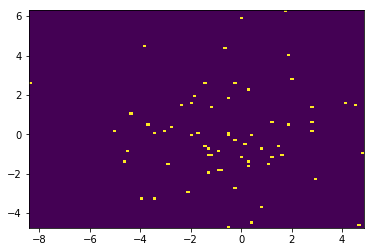

In [18]:
h = plt.hist2d(x1_list, x2_list, bins = [100, 100])

In [19]:
def log_gaussian(x):
    return -0.5*x**2 - 0.5*np.log(2*math.pi)

In [29]:
log_gaussian(2)

-2.9189385332046727

In [52]:
x = torch.tensor([[1.,1.],[1.,1.]]).cuda()

In [53]:
log_prior(x)

tensor([-2.8379, -2.8379], device='cuda:0')

In [3]:
def np_test(mean, cov_diag, x): 
    n = x.shape[0] # number of samples
    k = x.shape[1] # dimension
    t1 = -0.5*(x - mean)*(1/cov_diag)*(x-mean)
    t1 = np.sum(t1, axis = 1)
    #t2 = 0.5*k*torch.log(2*torch.tensor([math.pi]).cuda()) + 0.5*torch.log(torch.prod(cov_diag,1)).cuda()
    t2 = 0.5*k*np.log(2*math.pi) + 0.5*np.sum(np.log(cov_diag), axis = 1)
    #print("t1: "+str(t1)+"t2: "+str(t2))
    return t1 - t2

In [6]:
def multivariate_normal_diagonal_logpdf(mean, cov_diag, x):
    n = x.shape[0] # number of samples
    k = x.shape[1] # dimension
    t1 = -0.5*(x - mean)*(1/cov_diag)*(x-mean)
    t1 = torch.sum(t1, dim=1)
    print(t1)
    t21 = 0.5*k*torch.log(torch.tensor([2*math.pi])) 
    print(t21)
    t22 = 0.5*torch.sum(torch.log(cov_diag),dim=1)
    print(t22)
    t2 = t21 + t22
    return t1 - t2

In [4]:
mean = np.array([[0.,0.],[0.,0.]])
x = np.array([[1.,1.],[1.,1.]])
cov_diag = np.array([[1.,1.],[1.,1.]])
mean.shape

(2, 2)

In [7]:
mean = torch.tensor([[0.,0.],[0.,0.]])
x = torch.tensor([[1.,1.],[1.,1.]])
cov_diag = torch.tensor([[1.,1.],[1.,1.]])


In [8]:
multivariate_normal_diagonal_logpdf(mean, cov_diag, x)

tensor([-1., -1.])
tensor([ 1.8379])
tensor([ 0.,  0.])


tensor([-2.8379, -2.8379])

In [59]:
mean = torch.tensor([[0.,0.]]).cuda()
x = torch.tensor([[2.,2.]]).cuda()
cov_diag = torch.tensor([1.,1.]).cuda()

In [60]:
multivariate_normal_diagonal_logpdf(mean, cov_diag,x)

tensor([-5.8379], device='cuda:0')

In [71]:
x= np.array([[-0.9206,  4.3558]])
mean = np.array([[0.,  0.]])
cov_diag = np.array([[1.,  1.]])

In [72]:
np_test(mean, cov_diag, x)

-11.748126066409345

In [108]:
#q_z0_logvar = torch.zeros(z_dim, requires_grad=True).cuda()
q_z0_logvar = torch.tensor([[0.1,0.1]], requires_grad=True)
q_z0_mean = torch.zeros(2, requires_grad=True)

#q_z0_logvar_cuda = q_z0_logvar.cuda()
#q_z0_mean_cuda = q_z0_mean.cuda()

In [20]:
m = torch.tensor([[0.,0.],[0.,0.],[0.,0.]])
cov = torch.tensor([[1.,1.],[1.,1.],[1.,1.]])
x =  torch.tensor([[0.,1.],[1.,1.],[0.,0.]])
multivariate_normal_diagonal_logpdf(m, cov, x)

tensor([-2.3379, -2.8379, -1.8379])

In [136]:
log_prior(x)

torch.Size([3])

In [70]:
m = torch.tensor([[0.,0.],[0.,0.],[0.,0.]], requires_grad=True)
cov = torch.tensor([[1.,1.],[1.,1.],[1.,1.]], requires_grad=True)
x =  torch.tensor([[0.,1.],[1.,1.],[0.,0.]], requires_grad=True)
#loss = torch.mean(multivariate_normal_diagonal_logpdf(m, cov, x))
loss = torch.mean(log_prior(x))
loss.backward()
x.grad

tensor([[ 0.0000, -0.3333],
        [-0.3333, -0.3333],
        [ 0.0000,  0.0000]])

In [72]:
def new_normal(mean, cov_diag, x):
    n = x.shape[0] # number of samples
    k = x.shape[1] # dimension
    t1 = -0.5*(x - mean)**2*(1/cov_diag)#*(x-mean)
    print("t1: "+str(t1))
    t1 = torch.sum(t1, dim=1)
    print("t1: "+str(t1))
    #t2 = 0.5*k*torch.log(2*torch.tensor([math.pi]).cuda()) + 0.5*torch.log(torch.prod(cov_diag,1)).cuda()
    tmp = torch.log(cov_diag)
    print("tmp: "+str(tmp))
    print("0.5 sum tmp: "+str(0.5*torch.sum(tmp,dim=1)))
    
    t2 = 0.5*k*torch.log(torch.tensor([2*math.pi])) + 0.5*torch.sum(tmp,dim=1)
    print("t2: "+str(t2))
    #print("t1: "+str(t1)+"t2: "+str(t2))
    return t1 - t2

In [73]:
m = torch.tensor([[0.,0.],[0.,0.],[0.,0.]])
cov = torch.tensor([[2.,1.],[1.,1.],[1.,1.]])
x =  torch.tensor([[0.,1.],[1.,1.],[0.,0.]])


In [74]:
res = new_normal(m,cov,x)
print(res)

t1: tensor([[-0.0000, -0.5000],
        [-0.5000, -0.5000],
        [-0.0000, -0.0000]])
t1: tensor([-0.5000, -1.0000,  0.0000])
tmp: tensor([[ 0.6931,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000]])
0.5 sum tmp: tensor([ 0.3466,  0.0000,  0.0000])
t2: tensor([ 2.1845,  1.8379,  1.8379])
tensor([-2.6845, -2.8379, -1.8379])


In [59]:
m = torch.tensor([[0.,0.]])
cov = torch.tensor([[1.,0.],[0.,1.]])
x =  torch.tensor([[0.,0.]])
#cov = torch.eye(dim).cuda()
m = MultivariateNormal(m, cov)
m.requires_grad=True
m.log_prob(x)

tensor([-1.8379])

In [85]:
"""
def reparameterize(mu, logvar):
    std = torch.exp(0.5*logvar)
    eps = torch.randn_like(std)
    return eps.mul(std).add_(mu)
"""
def reparameterize(mu, logvar):
    std = torch.exp(0.5*logvar)
    eps = torch.randn_like(std)
    #return eps.mul(std).add_(mu)
    return eps*std+mu

def log_prior(z):
    dim = z.shape[1]
    mean = torch.zeros(dim)
    cov = torch.eye(dim)
    #print("mean: "+str(mean))
    #print("cov: "+str(cov))
    #print("z: "+str(z))
    m = MultivariateNormal(mean, cov)
    m.requires_grad=True
    return m.log_prob(z)

def multivariate_normal_diagonal_logpdf(mean, cov_diag, x):
    n = x.shape[0] # number of samples
    k = x.shape[1] # dimension
    t1 = -0.5*(x - mean)*(1/cov_diag)*(x-mean)
    t1 = torch.sum(t1, dim=1)
    #t2 = 0.5*k*torch.log(2*torch.tensor([math.pi]).cuda()) + 0.5*torch.log(torch.prod(cov_diag,1)).cuda()
    t2 = 0.5*k*torch.log(2*torch.tensor([math.pi])) + 0.5*torch.sum(torch.log(cov_diag),dim=1)
    #print("t1: "+str(t1)+"t2: "+str(t2))
    return t1 - t2

def test(z0, q_z0_mean, q_z0_logvar):
    num = q_z0_mean.shape[0]
    dim = q_z0_mean.shape[1]
    var_z0 = torch.exp(q_z0_logvar)
    log_q_z0 = multivariate_normal_diagonal_logpdf(q_z0_mean, var_z0, z0)
    log_prior_z0 = log_prior(z0)
    """
    m = torch.zeros([num, dim], requires_grad=True)
    v = torch.ones([num, dim], requires_grad=True)
    log_prior_z0 = multivariate_normal_diagonal_logpdf(m,v,z0)
    """
    L = log_prior_z0 - log_q_z0
    print(z0.shape)
    print(log_prior_z0)
    print(log_q_z0)
    #rint(L.shape)
    print("L: "+str(L))
    #return torch.mean(L)
    return torch.sum(L)

In [76]:
#mu = torch.tensor([[0.,0.],[0.,0.]])
#logvar = torch.tensor([[0.,0.],[0.,0.]])
def reparameterize(mu, logvar):
    std = torch.exp(0.5*logvar)
    eps = torch.randn_like(std)
    #return eps.mul(std).add_(mu)
    return eps*std+mu
mu = torch.ones([2,2], requires_grad=True)
logvar = torch.zeros([2,2], requires_grad=True)
z0 = reparameterize(mu, logvar)
loss = torch.sum(z0)
loss.backward()
mu.grad
z0

tensor([[ 2.9391,  0.8824],
        [ 0.1994,  0.6772]])

In [16]:
x1_list = []
x2_list = []
for i in range(z0.shape[0]):
    x1_list.append(z0[i][0])
    x2_list.append(z0[i][1])

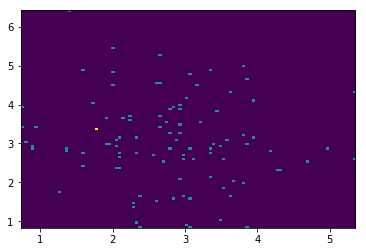

In [17]:
h = plt.hist2d(x1_list, x2_list, bins = [100, 100])

In [86]:
#q_z0_logvar = torch.tensor([[0.1,0.1]], requires_grad=True)
#q_z0_mean = torch.zeros(2, requires_grad=True)
num = 10
q_z0_logvar = torch.randn([num,2], requires_grad=True) 
q_z0_mean = torch.randn([num,2], requires_grad=True) 
#q_z0_logvar = torch.zeros([num,2], requires_grad=True) 
#q_z0_mean = torch.zeros([num,2], requires_grad=True) 

optimizer1 = optim.Adam([q_z0_mean], lr=0.005)
optimizer2 = optim.Adam([q_z0_logvar], lr=0.005)
ELBO_list = []

for i in range(800):
    #print(q_z0_logvar)
    #q_z0_logvar_cuda = q_z0_logvar.cuda()
    #q_z0_mean_cuda = q_z0_mean.cuda()
    z0 = reparameterize(q_z0_mean, q_z0_logvar)
    #print("z0: "+str(z0.shape))
    optimizer1.zero_grad()
    optimizer2.zero_grad()
    loss =  0. - test(z0,q_z0_mean, q_z0_logvar) 
    print("ELBO: "+str(0-loss.item()))
    ELBO_list.append(0-loss.item()/num)
    loss.backward()
    print(q_z0_logvar.grad)
    
    #print(q_z0_logvar)
    optimizer1.step()
    optimizer2.step()

torch.Size([10, 2])
tensor([-5.7420, -2.4156, -4.4273, -5.5792, -5.2144, -2.0721, -2.0346,
        -3.8857, -7.7556, -2.7357])
tensor([-2.8838, -2.3345, -4.4634, -1.8429, -3.4871, -3.3899, -1.1797,
        -5.8193, -4.9594, -2.2465])
L: tensor([-2.8582, -0.0811,  0.0361, -3.7363, -1.7273,  1.3178, -0.8548,
         1.9336, -2.7962, -0.4892])
ELBO: -9.255753517150879
tensor([[ 2.0224, -0.4828],
        [-0.2781, -0.4981],
        [-0.2135, -1.1379],
        [ 0.2928, -0.3367],
        [ 0.5049,  1.0256],
        [-0.5375, -0.0353],
        [-0.4443, -0.5379],
        [ 1.0454,  0.7579],
        [ 1.8298,  2.3243],
        [-0.1791, -0.4161]])
torch.Size([10, 2])
tensor([ -5.2901,  -4.5582, -10.7211, -17.2167,  -5.5537,  -5.3742,
         -2.3325,  -2.7705,  -7.7439,  -2.3187])
tensor([-3.4047, -4.1337, -5.6428, -5.1104, -3.6841, -3.6934, -1.3488,
        -2.0966, -5.7828, -2.2528])
L: tensor([ -1.8854,  -0.4245,  -5.0783, -12.1064,  -1.8696,  -1.6808,
         -0.9838,  -0.6739,  -1.961

tensor([[ 0.4955, -0.5458],
        [-0.4340, -0.1993],
        [-0.6829, -0.7785],
        [ 1.7850, -0.1317],
        [-0.5141, -0.0617],
        [ 0.6187,  2.9309],
        [ 0.6422,  0.0669],
        [-0.1986,  0.0045],
        [-0.3019,  4.8038],
        [-0.4877, -0.2169]])
torch.Size([10, 2])
tensor([ -6.2746,  -2.5696,  -8.3825,  -9.9138,  -5.8186,  -4.6406,
         -2.1614,  -1.9567, -12.0349,  -1.9991])
tensor([-4.9708, -3.0204, -3.2411, -4.1610, -4.5197, -4.8472, -1.5504,
        -2.4227, -5.3721, -2.3900])
L: tensor([-1.3038,  0.4508, -5.1414, -5.7528, -1.2989,  0.2066, -0.6110,
         0.4659, -6.6628,  0.3908])
ELBO: -19.25652503967285
tensor([[-0.2295,  2.5643],
        [ 0.2833, -0.2719],
        [ 2.4941, -0.8563],
        [ 3.5630,  0.5347],
        [ 2.9549, -0.4936],
        [-0.5170,  3.0320],
        [-0.3744, -0.4236],
        [-0.2790, -0.4889],
        [-0.3900,  9.6011],
        [-0.4622, -0.2526]])
torch.Size([10, 2])
tensor([ -3.0629,  -2.4618,  -7.5808,  

tensor([-2.3507, -2.2892, -3.6053, -3.8042, -1.9011, -8.9529, -2.0726,
        -2.5172, -4.7585, -2.1448])
tensor([-2.2564, -2.7272, -1.7879, -2.5847, -2.1651, -5.4948, -1.6566,
        -2.2261, -3.6063, -2.3857])
L: tensor([-0.0943,  0.4380, -1.8175, -1.2196,  0.2640, -3.4581, -0.4160,
        -0.2911, -1.1522,  0.2409])
ELBO: -7.505835056304932
tensor([[-0.4604, -0.3317],
        [ 0.0024, -0.3664],
        [-0.6896, -0.4444],
        [-0.5479,  0.2997],
        [-0.4578, -0.4801],
        [ 5.4840,  0.6714],
        [-0.4063, -0.4170],
        [-0.4228, -0.1007],
        [-0.3167,  2.3266],
        [-0.2508, -0.4433]])
torch.Size([10, 2])
tensor([-2.5343, -2.9462, -4.7522, -2.7421, -2.4916, -6.6319, -1.9758,
        -2.1162, -4.1329, -3.4981])
tensor([-2.3439, -3.2345, -3.2964, -2.5038, -2.3769, -4.3666, -1.7396,
        -2.1840, -3.4403, -4.2061])
L: tensor([-0.1904,  0.2884, -1.4559, -0.2383, -0.1147, -2.2652, -0.2361,
         0.0678, -0.6926,  0.7080])
ELBO: -4.12905216217041
te

tensor([-2.3897, -4.8544, -1.8585, -3.4766, -2.7265, -3.6119, -2.1487,
        -2.6519, -2.7250, -3.1321])
L: tensor([-0.3054, -1.7118, -2.0244, -1.6893,  0.2756, -0.8638, -0.1734,
        -0.1214,  0.6153, -0.0289])
ELBO: -6.027451515197754
tensor([[-0.1857, -0.2792],
        [ 2.5488,  0.7406],
        [-0.0576, -0.6569],
        [ 2.0824, -0.5492],
        [-0.2015, -0.0780],
        [ 0.3628,  0.9425],
        [-0.3730, -0.1809],
        [ 0.1632, -0.3408],
        [-0.2884, -0.3788],
        [ 0.6798, -0.4935]])
torch.Size([10, 2])
tensor([-2.5502, -2.0415, -2.3231, -2.6246, -3.3164, -3.7054, -2.5269,
        -1.9596, -4.9613, -1.9315])
tensor([-2.4261, -2.4445, -3.0749, -1.9233, -3.3139, -4.2748, -2.4331,
        -2.2239, -3.8425, -2.2165])
L: tensor([-0.1241,  0.4030,  0.7518, -0.7013, -0.0025,  0.5694, -0.0938,
         0.2643, -1.1188,  0.2849])
ELBO: 0.2328099012374878
tensor([[-0.4509, -0.1194],
        [-0.3203, -0.3867],
        [-0.0973, -0.7698],
        [-0.5374, -0.331

tensor([-4.0311, -2.3430, -1.7416, -2.1361, -2.8739, -2.7056, -4.0038,
        -2.8015, -2.7446, -2.6124])
L: tensor([-0.4283,  0.3596, -1.3538, -1.1700,  0.1858,  0.0859,  0.2419,
         0.0819, -0.2295, -0.3117])
ELBO: -2.5382988452911377
tensor([[-0.4046,  1.6152],
        [-0.4012, -0.4018],
        [-0.5150, -0.4722],
        [ 0.0634, -0.3393],
        [-0.1265,  0.0592],
        [-0.5057,  0.0102],
        [ 1.2453, -0.2673],
        [-0.0723, -0.0278],
        [-0.5018,  0.5849],
        [-0.3726,  0.3104]])
torch.Size([10, 2])
tensor([-2.4144, -5.7571, -3.1570, -2.2637, -7.8280, -2.6125, -2.6743,
        -3.8694, -3.0730, -2.0700])
tensor([-2.3581, -4.2865, -2.6640, -1.9868, -6.6564, -2.8968, -2.5496,
        -3.4889, -3.7020, -2.3049])
L: tensor([-0.0563, -1.4705, -0.4930, -0.2769, -1.1716,  0.2843, -0.1247,
        -0.3804,  0.6289,  0.2349])
ELBO: -2.8254499435424805
tensor([[-0.4193, -0.2232],
        [ 2.3180,  0.2312],
        [ 0.0704, -0.6461],
        [-0.4696, -0.4

torch.Size([10, 2])
tensor([-6.3618, -1.9278, -9.8746, -1.8701, -2.1581, -2.0497, -3.6316,
        -3.2359, -8.2450, -2.1522])
tensor([-4.7529, -2.2032, -5.5164, -2.1281, -2.2759, -2.4073, -3.6840,
        -3.0304, -5.0297, -2.1196])
L: tensor([-1.6090,  0.2754, -4.3582,  0.2580,  0.1178,  0.3575,  0.0524,
        -0.2054, -3.2153, -0.0326])
ELBO: -8.359379768371582
tensor([[ 2.2488,  0.8147],
        [-0.5069, -0.4120],
        [ 2.3618,  1.9881],
        [-0.5233, -0.5176],
        [-0.5023, -0.1620],
        [-0.5014, -0.4187],
        [ 1.2556, -0.4459],
        [ 0.3657, -0.0875],
        [-0.2527,  5.6425],
        [-0.4510, -0.2869]])
torch.Size([10, 2])
tensor([-4.4039, -5.8189, -5.8790, -3.6273, -1.9519, -3.9686, -3.6887,
        -1.9041, -2.1074, -4.0242])
tensor([-3.4608, -5.7909, -4.2134, -3.1970, -2.1151, -3.2243, -3.9587,
        -1.9615, -2.6178, -3.8929])
L: tensor([-0.9431, -0.0280, -1.6656, -0.4303,  0.1632, -0.7443,  0.2700,
         0.0574,  0.5104, -0.1313])
ELBO: 

torch.Size([10, 2])
tensor([-2.6814, -3.5714, -2.5771, -3.0711, -1.9876, -3.9691, -1.9391,
        -2.1753, -5.2866, -3.8767])
tensor([-2.8018, -3.5112, -2.3916, -3.3458, -2.1498, -4.1625, -1.8113,
        -2.2127, -3.7816, -3.6343])
L: tensor([ 0.1204, -0.0602, -0.1856,  0.2747,  0.1621,  0.1934, -0.1278,
         0.0375, -1.5051, -0.2424])
ELBO: -1.3328372240066528
tensor([[-0.5034,  0.2718],
        [ 1.2354, -0.3051],
        [-0.2499, -0.3936],
        [ 0.9633, -0.4316],
        [-0.3648, -0.4625],
        [-0.1981,  1.5600],
        [-0.4723, -0.4193],
        [-0.4137, -0.2517],
        [-0.4555,  2.8700],
        [ 0.3525,  0.6121]])
torch.Size([10, 2])
tensor([-2.6025, -2.8578, -2.1711, -1.9251, -4.2435, -3.9706, -4.7505,
        -2.4966, -2.3676, -2.8950])
tensor([-2.4560, -3.0421, -2.0953, -1.9498, -4.1338, -3.8463, -4.9305,
        -2.4591, -2.5285, -2.7538])
L: tensor([-0.1466,  0.1843, -0.0758,  0.0248, -0.1097, -0.1243,  0.1800,
        -0.0375,  0.1610, -0.1412])
ELBO:

tensor([-5.9193, -2.1312, -3.1167, -1.9338, -2.7962, -3.5349, -2.0281,
        -2.4062, -2.9230, -2.3786])
tensor([-4.7007, -2.3889, -3.7196, -2.2798, -2.7200, -3.2447, -1.9155,
        -2.3995, -2.7701, -2.4196])
L: tensor([-1.2186,  0.2578,  0.6029,  0.3459, -0.0762, -0.2902, -0.1126,
        -0.0067, -0.1528,  0.0410])
ELBO: -0.6094403266906738
tensor([[ 2.4529,  0.3884],
        [-0.1386, -0.4896],
        [ 0.9024, -0.5135],
        [-0.4867, -0.3879],
        [ 0.3830, -0.4663],
        [-0.4938,  0.9845],
        [-0.4861, -0.3204],
        [-0.4994,  0.0760],
        [-0.4981,  0.6227],
        [-0.3742, -0.0840]])
torch.Size([10, 2])
tensor([-3.2972, -2.0800, -4.3464, -4.0094, -2.9316, -2.3920, -2.6787,
        -3.8973, -2.1412, -2.4749])
tensor([-3.2771, -2.2293, -6.4603, -3.6640, -2.8339, -2.4947, -2.6335,
        -3.7580, -2.4349, -2.5920])
L: tensor([-0.0200,  0.1493,  2.1139, -0.3453, -0.0977,  0.1027, -0.0452,
        -0.1393,  0.2937,  0.1171])
ELBO: 2.1290948390960693


L: tensor([ 0.2960,  0.1580, -1.5408,  0.1999, -0.0724,  0.3282,  0.1236,
         0.0445,  0.3714, -0.0558])
ELBO: -0.14721941947937012
tensor([[-0.2193,  1.1512],
        [-0.4533, -0.4770],
        [ 1.2727, -0.2915],
        [ 0.1154, -0.4423],
        [ 1.0214, -0.1605],
        [-0.0413, -0.3695],
        [-0.4730,  0.8741],
        [-0.4575, -0.1789],
        [-0.3703, -0.4541],
        [-0.4035,  0.3019]])
torch.Size([10, 2])
tensor([-2.9200, -2.1631, -1.9673, -8.4641, -2.8046, -4.8246, -2.3815,
        -2.1779, -3.1775, -3.5801])
tensor([-2.8966, -2.3333, -2.7204, -5.9835, -2.9229, -3.9988, -2.3379,
        -2.1549, -2.9652, -3.7877])
L: tensor([-0.0234,  0.1703,  0.7531, -2.4806,  0.1183, -0.8258, -0.0436,
        -0.0230, -0.2123,  0.2076])
ELBO: -2.3593790531158447
tensor([[-0.4005,  0.3800],
        [-0.5008, -0.1906],
        [-0.2952, -0.3739],
        [ 5.7028, -0.4569],
        [ 0.2612, -0.2313],
        [ 2.2786, -0.3650],
        [-0.4418, -0.0211],
        [-0.4398

tensor([-3.1337, -2.5025, -1.9780, -3.7160, -3.4236, -3.2896, -3.8328,
        -2.9090, -2.4883, -2.1666])
L: tensor([-0.0158,  0.1324, -0.2359,  0.6070, -0.2810, -0.2641,  0.2851,
         0.0160,  0.0485, -0.0016])
ELBO: 0.2907235622406006
tensor([[ 0.8612, -0.4494],
        [-0.4104, -0.0676],
        [-0.4789, -0.3657],
        [-0.0026,  0.4896],
        [-0.0604,  0.8070],
        [ 1.0261, -0.3319],
        [ 0.1742,  0.6167],
        [-0.3486,  0.4366],
        [-0.4990,  0.0991],
        [-0.4846, -0.2031]])
torch.Size([10, 2])
tensor([-1.9426, -2.9884, -4.6715, -2.0606, -3.7024, -3.0071, -2.3318,
        -2.1647, -4.4619, -2.2936])
tensor([-2.0767, -3.0582, -3.9378, -2.0851, -3.4365, -3.0249, -2.2774,
        -2.1948, -4.3447, -2.4358])
L: tensor([ 0.1341,  0.0698, -0.7336,  0.0245, -0.2659,  0.0179, -0.0544,
         0.0301, -0.1171,  0.1422])
ELBO: -0.7524869441986084
tensor([[-0.4197, -0.4979],
        [-0.5006,  0.6196],
        [ 1.8406, -0.4820],
        [-0.3085, -0.47

tensor([-1.9870, -2.4141, -2.8494, -2.0289, -2.3323, -2.8856, -1.9030,
        -1.9006, -1.9378, -3.4256])
tensor([-2.1053, -2.5030, -2.2782, -2.2771, -2.2912, -2.8826, -1.8187,
        -1.9359, -2.1754, -3.2904])
L: tensor([ 0.1183,  0.0889, -0.5712,  0.2482, -0.0412, -0.0030, -0.0842,
         0.0353,  0.2376, -0.1353])
ELBO: -0.10653173923492432
tensor([[-0.4049, -0.4713],
        [ 0.0667, -0.4542],
        [-0.5132,  0.1619],
        [-0.4425, -0.2980],
        [-0.2943, -0.2577],
        [ 0.2514, -0.2094],
        [-0.4501, -0.4963],
        [-0.4725, -0.4632],
        [-0.5003, -0.4166],
        [ 0.5182,  0.0030]])
torch.Size([10, 2])
tensor([-2.0129, -2.5424, -2.3341, -3.5838, -2.1317, -2.5388, -2.3318,
        -2.8660, -4.0299, -2.0331])
tensor([-2.1506, -2.7444, -2.7668, -3.4928, -2.2543, -2.7841, -2.2291,
        -2.8666, -3.2808, -2.1078])
L: tensor([ 0.1377,  0.2020,  0.4326, -0.0910,  0.1226,  0.2454, -0.1028,
         0.0006, -0.7492,  0.0747])
ELBO: 0.2727746963500976

tensor([-1.9823, -3.0905, -2.0062, -3.5395, -2.8789, -1.8865, -2.9788,
        -3.2836, -3.6109, -4.5119])
tensor([-2.1440, -2.8180, -1.9112, -3.5876, -2.8589, -2.1042, -3.0217,
        -3.2892, -3.3012, -4.2368])
L: tensor([ 0.1617, -0.2724, -0.0950,  0.0481, -0.0201,  0.2178,  0.0429,
         0.0056, -0.3097, -0.2752])
ELBO: -0.49626433849334717
tensor([[-0.3562, -0.4866],
        [ 0.6597, -0.4934],
        [-0.4019, -0.5028],
        [ 0.2695,  0.4322],
        [ 0.2916, -0.2648],
        [-0.4905, -0.4560],
        [-0.4214,  0.5718],
        [ 0.9508, -0.4993],
        [-0.0269,  0.7610],
        [ 0.2519,  1.3529]])
torch.Size([10, 2])
tensor([-3.7232, -4.2785, -2.7583, -2.0134, -3.1819, -3.3491, -1.9355,
        -2.0689, -4.2507, -3.6352])
tensor([-3.4502, -4.0105, -2.6792, -2.1315, -3.2343, -3.4022, -1.9214,
        -2.0490, -3.5237, -3.5026])
L: tensor([-0.2729, -0.2680, -0.0791,  0.1181,  0.0525,  0.0531, -0.0142,
        -0.0200, -0.7270, -0.1326])
ELBO: -1.290149450302124

tensor([-3.9586, -3.7078, -2.1452, -1.9916, -2.2121, -2.1606, -2.1305,
        -1.9151, -3.8447, -3.0507])
L: tensor([ 0.2446, -0.5128,  0.2118,  0.0175,  0.1298,  0.1033,  0.0374,
        -0.0053,  0.0655,  0.0935])
ELBO: 0.385357141494751
tensor([[-0.4155,  1.3169],
        [ 1.2978, -0.0771],
        [-0.4993, -0.3258],
        [-0.4791, -0.4072],
        [-0.4453, -0.2718],
        [-0.3964, -0.4102],
        [-0.2764, -0.4474],
        [-0.4994, -0.4204],
        [ 0.8200,  0.1893],
        [-0.3665,  0.5420]])
torch.Size([10, 2])
tensor([-3.0470, -1.9059, -2.0492, -3.3087, -3.1789, -2.5242, -2.9403,
        -2.1731, -2.3055, -6.4787])
tensor([-3.0343, -2.0102, -2.3330, -3.3424, -3.0166, -2.7010, -2.8445,
        -2.2054, -2.5099, -6.0343])
L: tensor([-0.0127,  0.1043,  0.2839,  0.0337, -0.1624,  0.1768, -0.0958,
         0.0323,  0.2044, -0.4444])
ELBO: 0.12016022205352783
tensor([[ 0.5010, -0.2388],
        [-0.4903, -0.4620],
        [-0.3266, -0.3502],
        [ 0.6560, -0.098

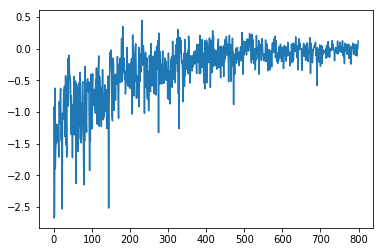

In [87]:
plt.plot(ELBO_list)

tensor([-1.], device='cuda:0')